![enter image description here](https://img.shields.io/badge/Author-Nestor_Batista_Díaz-yellow)

# <center> PREDICCIÓN DE LA DUREZA DE MOH</center>


## IMPORTS

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import Lasso

from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import  train_test_split, cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.metrics import make_scorer, median_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor


from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

import joblib
import streamlit as st

## DATASET

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/Nestorbd/Prediction-of-Mohs-Hardness/master/Mineral_Dataset_Supplementary_Info.csv").drop('Unnamed: 0', axis=1)
target = df.pop("Hardness")
df.insert(df.shape[1], "Hardness", target)
df.shape

(622, 12)

### OVERVIEW

In [3]:
df.describe()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
count,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000
mean,312.895691,27.864836,14.808027,4.419379,32.243577,11.108756,2.626550,1.670637,0.875162,0.514876,1.925111,4.613987
std,853.331650,39.243940,9.963898,0.807960,24.586056,1.748614,0.402856,0.256487,0.197932,0.095138,1.944419,1.729636
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,98.250000,10.561656,9.371995,4.058333,18.833820,10.961967,2.629196,1.612857,0.796770,0.482455,0.738097,3.000000
50%,186.500000,20.744196,10.852814,4.636364,22.197615,11.359643,2.708831,1.713333,0.887321,0.496546,1.032304,5.500000
75%,390.000000,34.824490,17.416667,4.800000,38.852958,11.804828,2.774951,1.763561,0.949722,0.538921,2.337138,5.950000
max,15300.000000,643.093804,67.000000,6.000000,167.400000,14.163933,3.426381,2.250000,1.500000,0.770755,10.970000,10.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622 entries, 0 to 621
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     622 non-null    float64
 1   density_Total          622 non-null    float64
 2   allelectrons_Average   622 non-null    float64
 3   val_e_Average          622 non-null    float64
 4   atomicweight_Average   622 non-null    float64
 5   ionenergy_Average      622 non-null    float64
 6   el_neg_chi_Average     622 non-null    float64
 7   R_vdw_element_Average  622 non-null    float64
 8   R_cov_element_Average  622 non-null    float64
 9   zaratio_Average        622 non-null    float64
 10  density_Average        622 non-null    float64
 11  Hardness               622 non-null    float64
dtypes: float64(12)
memory usage: 58.4 KB


### ANÁLISIS DE DATOS

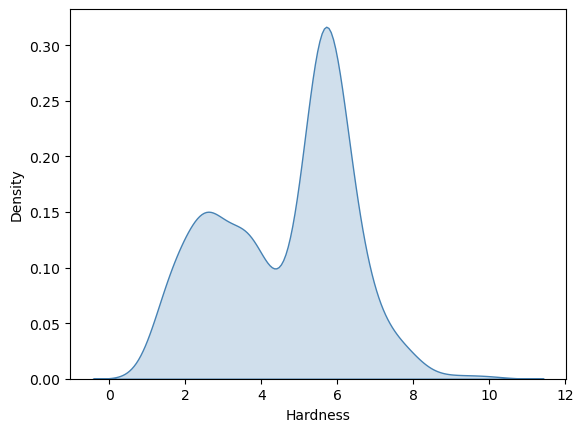

In [5]:
sns.kdeplot(data = df, x = 'Hardness', fill = True, color = 'steelblue');

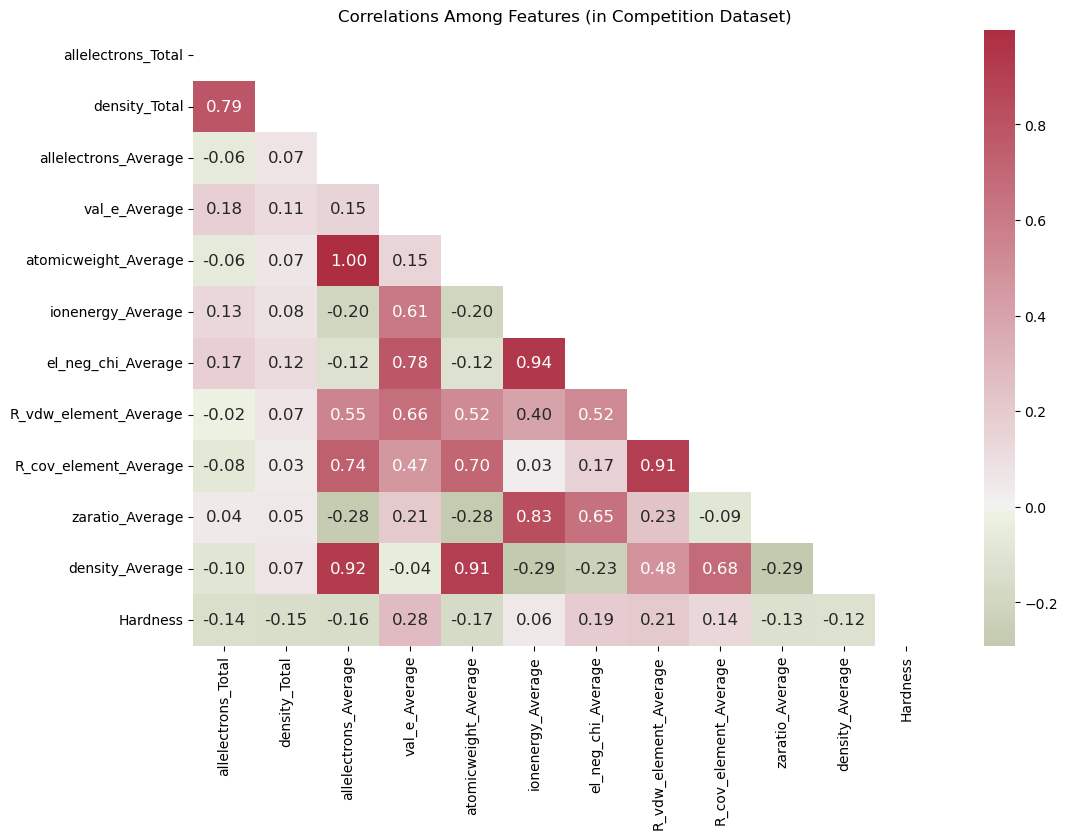

In [6]:
corr_mat_data = df.corr()
data_mask = np.triu(np.ones_like(corr_mat_data, dtype = bool))

cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 5, center = 'light', as_cmap = True)

plt.figure(figsize = (12, 8))
sns.heatmap(corr_mat_data, annot = True, cmap = cmap, fmt = '.2f', center = 0,
            annot_kws = {'size': 12}, mask = data_mask).set_title('Correlations Among Features (in Competition Dataset)');

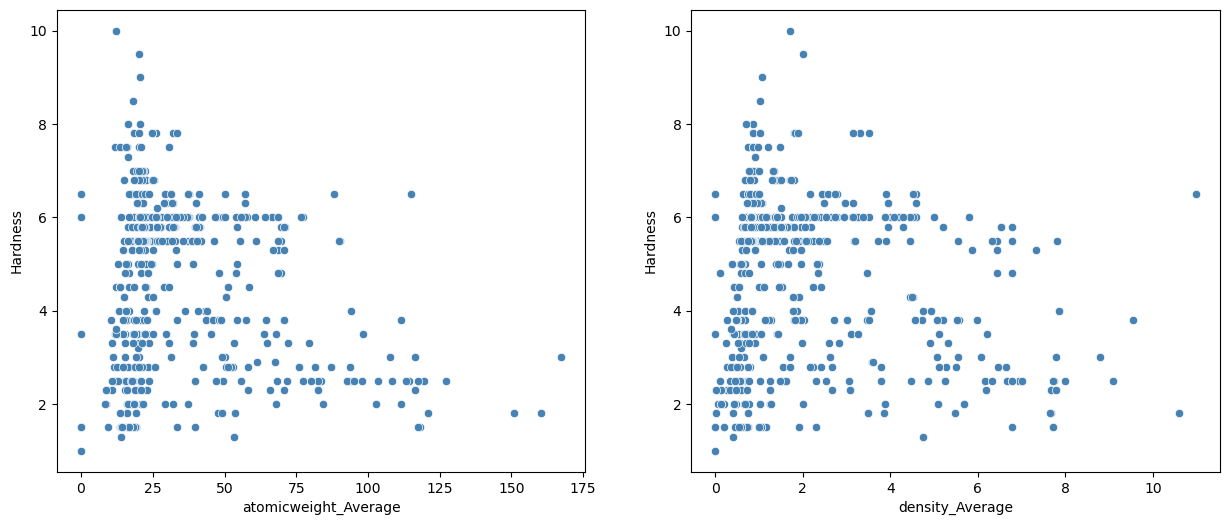

In [7]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.scatterplot(ax = axes[0], data = df, x = 'atomicweight_Average', y = 'Hardness', color = 'steelblue')
sns.scatterplot(ax = axes[1], data = df, x = 'density_Average', y = 'Hardness', color = 'steelblue');

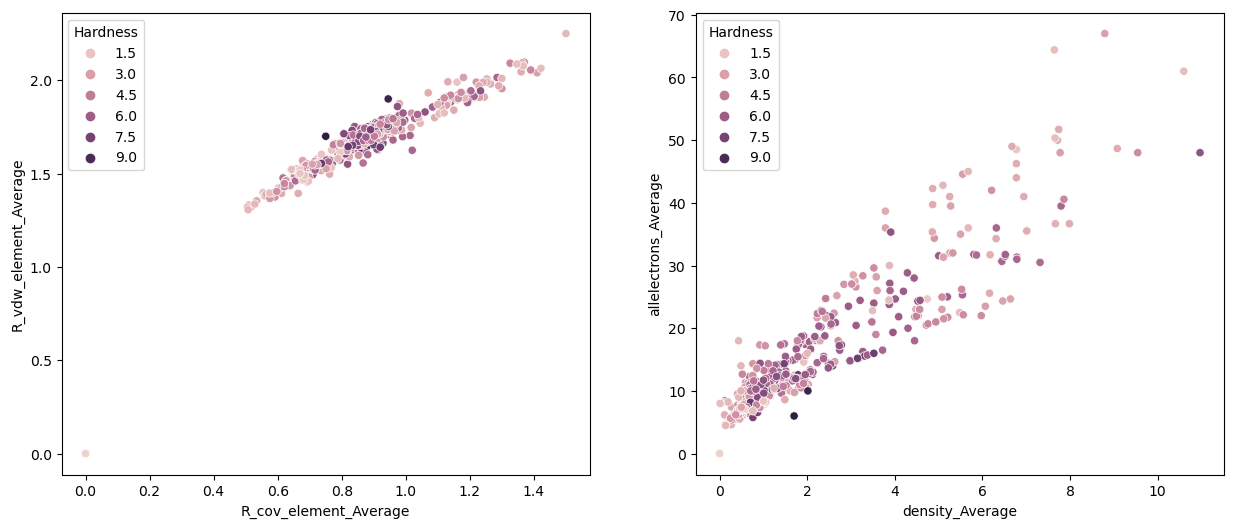

In [8]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.scatterplot(ax = axes[0], data = df, x = 'R_cov_element_Average', y = 'R_vdw_element_Average', hue = 'Hardness')
sns.scatterplot(ax = axes[1], data = df, x = 'density_Average', y = 'allelectrons_Average', hue = 'Hardness');

## PROCESAMIENTO DE DATOS

### SELECCIÓN DE CARACTERÍSTICAS

In [9]:
X = df.drop('Hardness', axis=1)
y = df['Hardness']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el modelo de regresión LASSO
lasso_model = Lasso(alpha=1.0)

# Entrenar el modelo
lasso_model.fit(X_train, y_train)

# Obtener los coeficientes no nulos (características seleccionadas)
selected_features = X.columns[lasso_model.coef_ != 0]

# Mostrar las características seleccionadas
print("Características seleccionadas:", selected_features)

Características seleccionadas: Index(['allelectrons_Total', 'density_Total', 'atomicweight_Average'], dtype='object')


### OUTLIERS

In [10]:
df_columns_selected = df[selected_features]
k=1.8 
for i,column in enumerate(df_columns_selected,1):
  print(column)
  Q1 = np.quantile(df_columns_selected[column],0.25)
  Q3 = np.quantile(df_columns_selected[column],0.75)
  IQR = Q3 - Q1 
  xL=Q1 - k * IQR
  xU=Q3 + k * IQR
  print(f" Banda= [ {xL},{xU}]")
  outlaiers = 0
  for x in  range(len(df_columns_selected)):
          if df_columns_selected[column][x] < xL  or df_columns_selected[column][x]>xU:
               outlaiers +=1
            # print(f" El dato[{x}]={df_columns_selected[column][x]} es un outlier")
  print(f"Hay {outlaiers} outlaiers")

allelectrons_Total
 Banda= [ -426.9,915.15]
Hay 14 outlaiers
density_Total
 Banda= [ -33.11144520000001,78.49759120000002]
Hay 16 outlaiers
atomicweight_Average
 Banda= [ -17.20062643977206,74.8874043184249]
Hay 44 outlaiers


In [11]:
# Calcular el rango intercuartílico (IQR) para cada columna
Q1 = df_columns_selected[selected_features].quantile(0.25)
Q3 = df_columns_selected[selected_features].quantile(0.75)
IQR = Q3 - Q1
xL=Q1 - k * IQR
xU=Q3 + k * IQR

# Definir un filtro para eliminar outliers
filtro_outliers = ~((df_columns_selected[selected_features] < xL) | (df_columns_selected[selected_features] > xU)).any(axis=1)

# Aplicar el filtro para mantener solo los datos sin outliers
df_sin_outliers = df[filtro_outliers].reset_index(drop=True)

# Visualizar la diferencia de filas
outlaiers = df.shape[0]- df_sin_outliers.shape[0]

# Verificar la forma del DataFrame después de eliminar outliers
print(f'Forma del DataFrame antes de eliminar outliers: {df_columns_selected.shape}')
print(f'Forma del DataFrame después de eliminar outliers: {df_sin_outliers.shape}')
print(f'Se han eliminado {outlaiers} outliers')

Forma del DataFrame antes de eliminar outliers: (622, 3)
Forma del DataFrame después de eliminar outliers: (557, 12)
Se han eliminado 65 outliers


### NORMALIZACIÓN

In [12]:
column_names = df_sin_outliers.columns.values
index_to_remove = np.where(column_names == 'Hardness')[0]
column_names = np.delete(column_names, index_to_remove)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_sin_outliers.drop('Hardness', axis=1))
scaled_df = pd.DataFrame(scaled_data, columns=column_names)

## ENTRENAMIENTO

In [13]:
X = df_sin_outliers[selected_features]
y = df_sin_outliers['Hardness']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### LinearRegresion

#### SIN CROSS VALIDATION

In [14]:
model_LinearRegression_sin_cross_val = LinearRegression()
model_LinearRegression_sin_cross_val.fit(X_train, y_train)
# Predicciones en el conjunto de prueba
predicciones_sin_cross_val = model_LinearRegression_sin_cross_val.predict(X_test)

# Calcular el error cuadrático medio sin cross-validation
mae_sin_cv = median_absolute_error(y_test, predicciones_sin_cross_val)
print(f'Mediana del error absoluto (MAE) sin cross-validation: {mae_sin_cv}')

Mediana del error absoluto (MAE) sin cross-validation: 1.1282394005222645


#### CON CROSS VALIDATION

In [15]:
# Función de puntuación personalizada (MAE en este ejemplo)
def custom_scorer(y_true, y_pred):
    mae = median_absolute_error(y_true, y_pred)
    return mae

# Convertir el puntuador personalizado en un puntuador compatible con cross_val_score
scorer = make_scorer(custom_scorer, greater_is_better=False)

In [16]:
skf = KFold(n_splits = 5)

model_LinearRegression_con_cross_val = LinearRegression()

predicciones_con_cross_val = cross_val_score(model_LinearRegression_con_cross_val, X_train, y_train, scoring=scorer, cv=skf, n_jobs=-1)
cv_mae_linearRegression = -np.mean(predicciones_con_cross_val)

print(f'Error cuadrático medio con LinearRegression con cross-validation: {cv_mae_linearRegression}')

Error cuadrático medio con LinearRegression con cross-validation: 1.1066564581346663


#### COMPARACIÓN

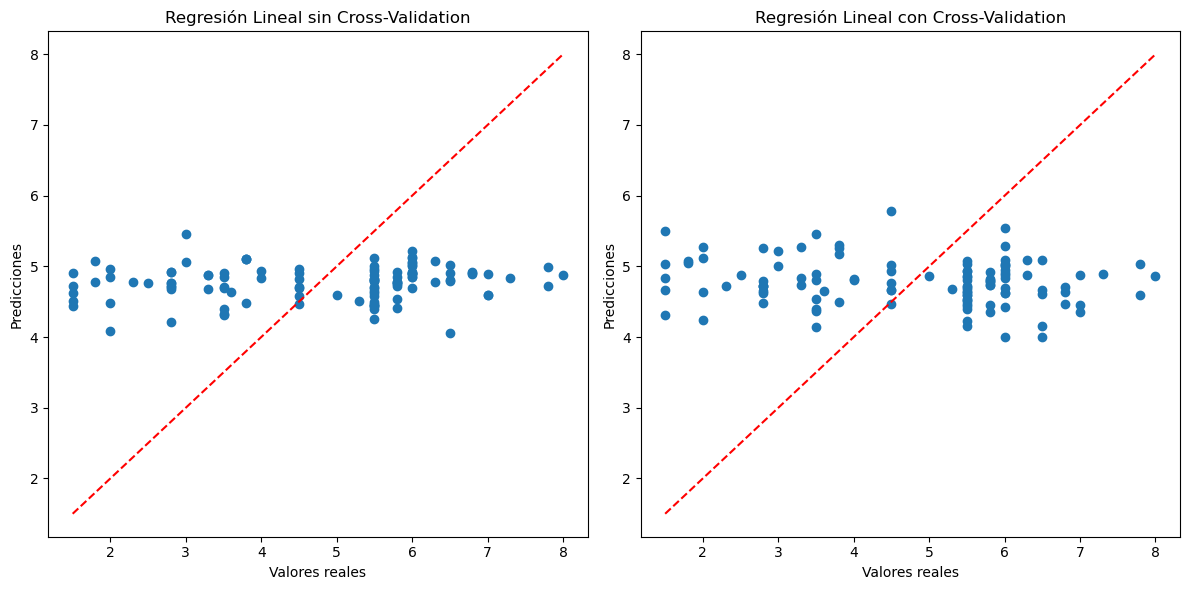

In [17]:
# Visualizar resultados
plt.figure(figsize=(12, 6))

# Gráfico para el modelo sin cross-validation
plt.subplot(1, 2, 1)
plt.scatter(y_test, predicciones_sin_cross_val)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.title('Regresión Lineal sin Cross-Validation')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')

# Gráfico para el modelo con cross-validation
plt.subplot(1, 2, 2)
plt.scatter(y_test, cross_val_predict(model_LinearRegression_con_cross_val, X_test, y_test, cv=skf))
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.title('Regresión Lineal con Cross-Validation')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')

plt.tight_layout()
plt.show()

### KNN

Mejores Parámetros: {'n_neighbors': 1, 'weights': 'uniform'} MAE: 0.45999999999999996


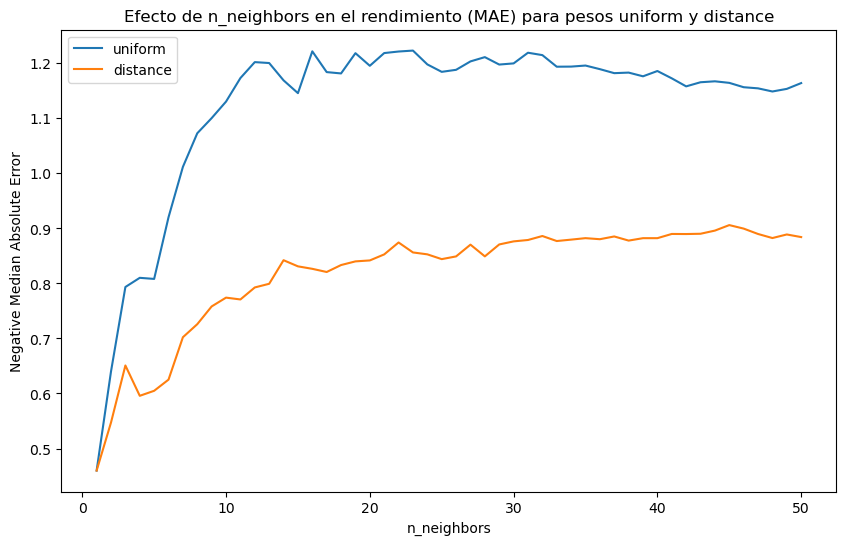

In [18]:
# Define el espacio de búsqueda de parámetros
param_grid = {'n_neighbors': np.arange(1, 51), 'weights': ['uniform', 'distance']}

# Crea el modelo KNN
knn = KNeighborsRegressor()

# Realiza la búsqueda de hiperparámetros utilizando Grid Search
grid_search_knn = GridSearchCV(knn, param_grid, cv=skf, scoring="neg_median_absolute_error")
grid_search_knn.fit(X_train, y_train)

# Obtiene los resultados
resultados = grid_search_knn.cv_results_
mejores_parametros = grid_search_knn.best_params_

# Extrae los resultados para 'uniform' y 'distance'
scores_uniform = -resultados['mean_test_score'][resultados['param_weights'] == 'uniform']
scores_distance = -resultados['mean_test_score'][resultados['param_weights'] == 'distance']
parametros = resultados['param_n_neighbors'][resultados['param_weights'] == 'uniform']

# Imprime los mejores parámetros encontrados
print("Mejores Parámetros:", mejores_parametros, "MAE:", -grid_search_knn.best_score_)

# Dibuja la gráfica
plt.figure(figsize=(10, 6))
plt.plot(parametros, scores_uniform, label='uniform')
plt.plot(parametros, scores_distance, label='distance')
plt.title('Efecto de n_neighbors en el rendimiento (MAE) para pesos uniform y distance')
plt.xlabel('n_neighbors')
plt.ylabel('Negative Median Absolute Error')
plt.legend()
plt.show()


In [19]:
results = pd.DataFrame(resultados)
results = results.sort_values(by='rank_test_score')
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001196,0.000398,0.002197,0.000399,1,uniform,"{'n_neighbors': 1, 'weights': 'uniform'}",-0.300000,-0.500000,-0.500000,-0.500000,-0.500000,-0.460000,0.080000,1
1,0.001396,0.000489,0.001994,0.000002,1,distance,"{'n_neighbors': 1, 'weights': 'distance'}",-0.300000,-0.500000,-0.500000,-0.500000,-0.500000,-0.460000,0.080000,1
3,0.001995,0.000631,0.002793,0.001323,2,distance,"{'n_neighbors': 2, 'weights': 'distance'}",-0.506774,-0.605742,-0.653143,-0.470632,-0.500000,-0.547258,0.069823,3
7,0.001396,0.000489,0.001197,0.000399,4,distance,"{'n_neighbors': 4, 'weights': 'distance'}",-0.612532,-0.700000,-0.612479,-0.500000,-0.553874,-0.595777,0.066860,4
9,0.000997,0.000000,0.001197,0.000399,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",-0.627254,-0.691354,-0.663203,-0.500000,-0.542465,-0.604855,0.072492,5


In [20]:

model_knn = KNeighborsRegressor(**mejores_parametros)

# Use cross_val_score with the pipeline
kn_cv_scores = cross_val_score(model_knn, X_train, y_train, cv=skf, n_jobs=-1, scoring="neg_median_absolute_error")


print("Scores: ",-kn_cv_scores)
print(f'Mediana del error absoluto (MAE) con el modelo KNN: {-kn_cv_scores.mean()}')


Scores:  [0.3 0.5 0.5 0.5 0.5]
Mediana del error absoluto (MAE) con el modelo KNN: 0.45999999999999996


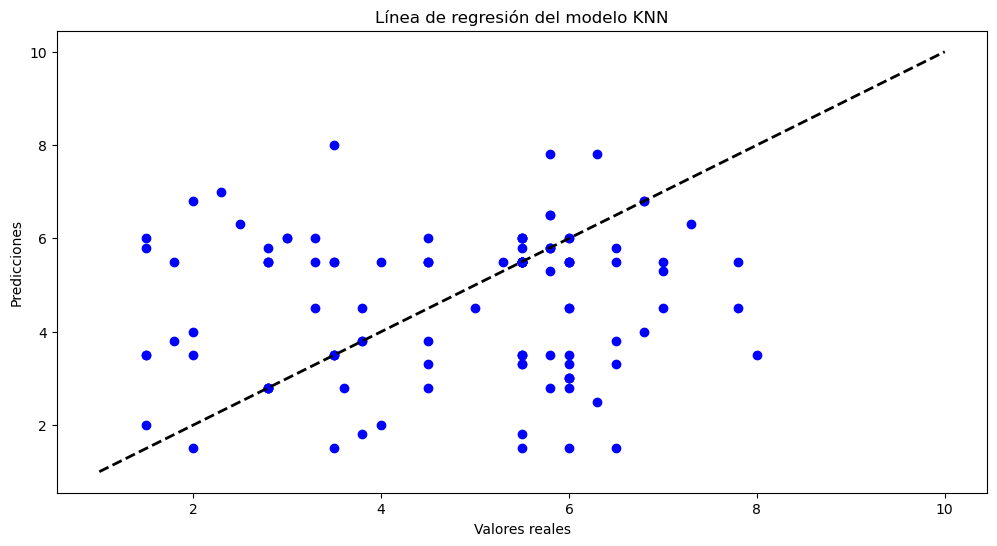

In [21]:
# Realizar la validación cruzada para obtener las predicciones
y_pred = cross_val_predict(model_knn, X_test, y_test, cv=skf)

# Visualizar resultados
plt.figure(figsize=(12, 6))
# Trazar la línea de regresión
plt.scatter(y_test,y_pred, color='b')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Línea de regresión del modelo KNN')
plt.show()

## Árboles

### RandomForestRegressor

In [22]:
# Definir los parámetros a buscar
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Crear el modelo de RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Realiza la búsqueda de hiperparámetros utilizando Grid Search
grid_search_rfg = GridSearchCV(rf, param_grid, cv=skf, scoring="neg_median_absolute_error")
grid_search_rfg.fit(X_train, y_train)

# Obtiene los resultados
resultados = grid_search_rfg.cv_results_
mejores_parametros = grid_search_rfg.best_params_

# Imprime los mejores parámetros encontrados
print("Mejores Parámetros:", mejores_parametros, "MAE:", -grid_search_rfg.best_score_)

Mejores Parámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100} MAE: 0.48858523809523985


In [23]:
results = pd.DataFrame(resultados)
results = results.sort_values(by='rank_test_score')
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.241367,0.007651,0.006638,0.000541,None,1,2,100,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",-0.478593,-0.394667,-0.614000,-0.525000,-0.430667,-0.488585,0.076590,1
2,0.705025,0.022654,0.018166,0.000971,None,1,2,300,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",-0.421000,-0.386806,-0.651944,-0.528000,-0.478667,-0.493283,0.092903,2
82,0.428253,0.004983,0.012170,0.000414,15,1,2,200,"{'max_depth': 15, 'min_samples_leaf': 1, 'min_...",-0.429201,-0.382014,-0.638582,-0.536215,-0.491271,-0.495457,0.088795,3
56,0.565882,0.006356,0.017160,0.000397,10,1,2,300,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",-0.415753,-0.415899,-0.590066,-0.561511,-0.499605,-0.496567,0.072121,4
81,0.214836,0.002404,0.006171,0.000389,15,1,2,100,"{'max_depth': 15, 'min_samples_leaf': 1, 'min_...",-0.450376,-0.410000,-0.631881,-0.529128,-0.468911,-0.498059,0.077138,5


In [24]:
# Crear el modelo de Random Forest
model_randomForestRegressor = RandomForestRegressor(**mejores_parametros, random_state=42)

# Realizar la validación cruzada con 5 particiones (k=5)
mae_scores = cross_val_score(model_randomForestRegressor, X_train, y_train, cv=skf, scoring="neg_median_absolute_error")

print("Scores: ",-mae_scores)
print('Mediana del error absoluto (MAE) con el modelo RandomForestRegressor:', -mae_scores.mean())


Scores:  [0.47859286 0.39466667 0.614      0.525      0.43066667]
Mediana del error absoluto (MAE) con el modelo RandomForestRegressor: 0.48858523809523985


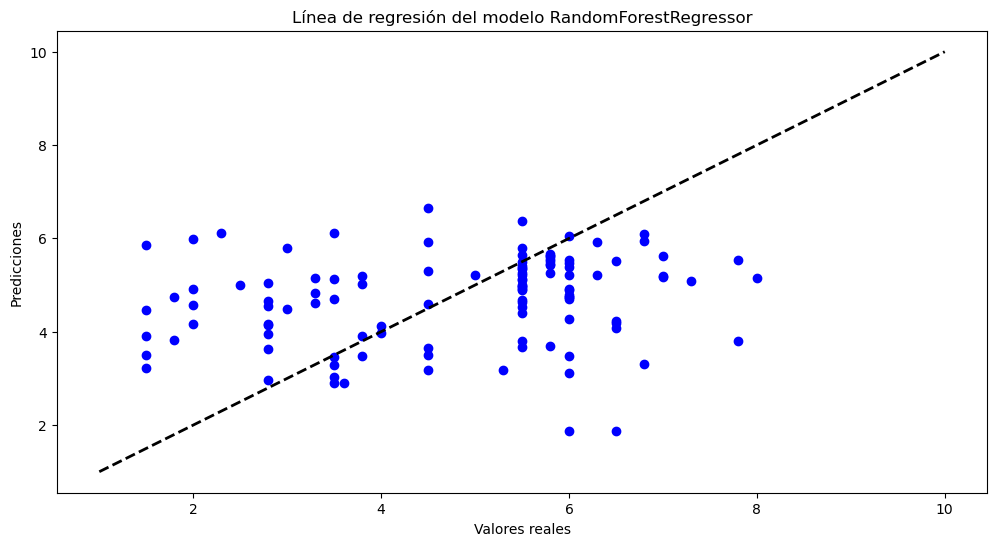

In [25]:
# Realizar la validación cruzada para obtener las predicciones
y_pred = cross_val_predict(model_randomForestRegressor, X_test, y_test, cv=skf)

# Visualizar resultados
plt.figure(figsize=(12, 6))
# Trazar la línea de regresión
plt.scatter(y_test,y_pred, color='b')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Línea de regresión del modelo RandomForestRegressor')
plt.show()

### GradientBoostingRegressor

In [26]:
# Definir los parámetros a buscar
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}

# Crear el modelo de GradientBoostingRegressor
gbm = GradientBoostingRegressor(random_state=42)

# Realizar la búsqueda en cuadrícula
grid_search_gbr = GridSearchCV(gbm, param_grid, cv=skf, scoring="neg_median_absolute_error")
grid_search_gbr.fit(X_train, y_train)

# Obtener los mejores parámetros
best_params = grid_search_gbr.best_params_
print("Mejores parámetros:", best_params, "MAE:", -grid_search_gbr.best_score_)

Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 200} MAE: 0.46819381764699913


In [27]:
results = pd.DataFrame(grid_search_gbr.cv_results_)
results = results.sort_values(by='rank_test_score')
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
142,0.274267,0.013948,0.001795,0.001164,0.1,5,1,4,200,"{'learning_rate': 0.1, 'max_depth': 5, 'min_sa...",-0.426683,-0.432228,-0.516907,-0.411273,-0.553878,-0.468194,0.056518,1
136,0.271480,0.003034,0.001794,0.000746,0.1,5,1,2,200,"{'learning_rate': 0.1, 'max_depth': 5, 'min_sa...",-0.445785,-0.386958,-0.601061,-0.419210,-0.497428,-0.470089,0.074821,2
56,0.398416,0.004970,0.001994,0.000004,0.05,5,1,2,300,"{'learning_rate': 0.05, 'max_depth': 5, 'min_s...",-0.408766,-0.423427,-0.550075,-0.424425,-0.557319,-0.472802,0.066322,3
137,0.400729,0.005611,0.001796,0.000398,0.1,5,1,2,300,"{'learning_rate': 0.1, 'max_depth': 5, 'min_sa...",-0.442104,-0.396883,-0.592345,-0.419689,-0.524718,-0.475148,0.072781,4
59,0.393745,0.003465,0.001395,0.000490,0.05,5,1,3,300,"{'learning_rate': 0.05, 'max_depth': 5, 'min_s...",-0.419450,-0.474963,-0.540293,-0.405313,-0.539644,-0.475933,0.057236,5


In [28]:
# Entrenar el modelo con los mejores parámetros
model_gradientBoostingRegressor = GradientBoostingRegressor(**best_params, random_state=42)

mae_scores = cross_val_score(model_gradientBoostingRegressor, X_train, y_train, cv=skf, scoring="neg_median_absolute_error")

print("Scores: ",-mae_scores)
print('Mediana del error absoluto (MAE) con el modelo GradientBoostingRegressor:', -mae_scores.mean())

Scores:  [0.42668344 0.43222764 0.51690732 0.41127252 0.55387817]
Mediana del error absoluto (MAE) con el modelo GradientBoostingRegressor: 0.46819381764699913


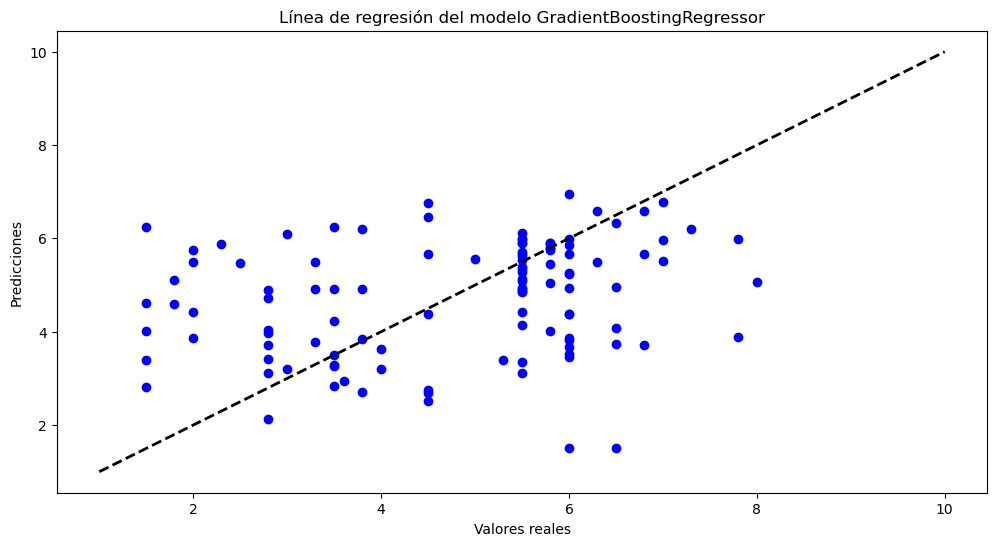

In [29]:
# Realizar la validación cruzada para obtener las predicciones
y_pred = cross_val_predict(model_gradientBoostingRegressor, X_test, y_test, cv=skf)

# Visualizar resultados
plt.figure(figsize=(12, 6))
# Trazar la línea de regresión
plt.scatter(y_test,y_pred, color='b')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Línea de regresión del modelo GradientBoostingRegressor')
plt.show()

### XGBoost

In [30]:
# Definir los parámetros a buscar
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'gamma': [0.1, 0.2, 0.3]
}

# Crear el modelo de XGBoost
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', random_state=42)

# Realizar la búsqueda en cuadrícula
grid_search_xgb = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=skf, scoring="neg_median_absolute_error")
grid_search_xgb.fit(X_train, y_train)

# Obtener los mejores parámetros
mejores_parametros = grid_search_xgb.best_params_
print("Mejores parámetros:", best_params, "MAE:", -grid_search_xgb.best_score_)

Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 200} MAE: 0.5102458477020264


In [31]:
results = pd.DataFrame(grid_search_xgb.cv_results_)
results = results.sort_values(by='rank_test_score')
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
242,0.039893,0.000892,0.002194,3.988267e-04,0.3,0.2,5,3,300,"{'gamma': 0.3, 'learning_rate': 0.2, 'max_dept...",-0.492292,-0.461470,-0.614704,-0.493043,-0.489721,-0.510246,0.053535,1
240,0.020545,0.001353,0.002194,3.982783e-04,0.3,0.2,5,3,100,"{'gamma': 0.3, 'learning_rate': 0.2, 'max_dept...",-0.492292,-0.461470,-0.614704,-0.493043,-0.489721,-0.510246,0.053535,1
241,0.028923,0.001669,0.002394,4.881692e-04,0.3,0.2,5,3,200,"{'gamma': 0.3, 'learning_rate': 0.2, 'max_dept...",-0.492292,-0.461470,-0.614704,-0.493043,-0.489721,-0.510246,0.053535,1
52,0.043483,0.002326,0.001995,0.000000e+00,0.1,0.1,5,3,200,"{'gamma': 0.1, 'learning_rate': 0.1, 'max_dept...",-0.460348,-0.397241,-0.603428,-0.502199,-0.641427,-0.520928,0.090162,4
53,0.050664,0.001163,0.001995,8.203817e-07,0.1,0.1,5,3,300,"{'gamma': 0.1, 'learning_rate': 0.1, 'max_dept...",-0.460348,-0.397241,-0.603433,-0.502199,-0.641427,-0.520929,0.090162,5


In [32]:

# Entrenar el modelo con los mejores parámetros
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', **mejores_parametros, random_state=42)

mae_scores = cross_val_score(model_xgb, X_train, y_train, cv=skf, scoring="neg_median_absolute_error")

# Evaluar el modelo
print("Scores: ",-mae_scores)
print('Mediana del error absoluto (MAE) con el modelo XGBRegressor:', -mae_scores.mean())

Scores:  [0.49229193 0.46146994 0.61470389 0.49304295 0.48972054]
Mediana del error absoluto (MAE) con el modelo XGBRegressor: 0.5102458477020264


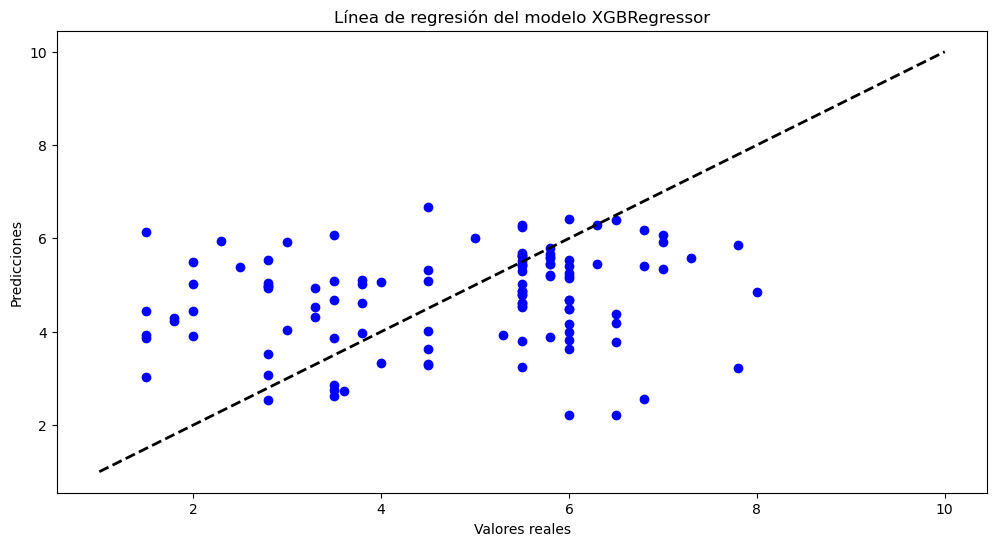

In [33]:
# Realizar la validación cruzada para obtener las predicciones
y_pred = cross_val_predict(model_xgb, X_test, y_test, cv=skf)

# Visualizar resultados
plt.figure(figsize=(12, 6))
# Trazar la línea de regresión
plt.scatter(y_test,y_pred, color='b')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Línea de regresión del modelo XGBRegressor')
plt.show()


## Exportar modelo en .pkl

In [34]:
# Exportar el modelo a un fichero
joblib.dump(grid_search_knn,'mohs_hardness_knn_modelo_entrenado.pkl')

['mohs_hardness_knn_modelo_entrenado.pkl']

## Importar modelo .pkl

In [35]:
modelo_knn_entrenado = KNeighborsRegressor()
modelo_knn_entrenado = joblib.load('mohs_hardness_knn_modelo_entrenado.pkl')
-modelo_knn_entrenado.score(X_test, y_test)

0.3999999999999999

In [36]:
test = pd.read_csv("test.csv")
test

,id,allelectrons_Total,density_Total,atomicweight_Average,Hardness
0,1,40.0,3.18,18.99,4.0
1,2,164.0,19.92,32.00,6.5
2,3,605.2,61.36,27.92,4.5
3,4,30.0,2.75,60.08,7.0
4,5,6.0,3.50,14.00,10.0
5,6,70.0,5.82,20.10,7.0


In [37]:
pred = modelo_knn_entrenado.predict(test[selected_features])

output = pd.DataFrame({ 'id': test['id'], 'hardness_pred': pred, 'real_hardness': test["Hardness"]})
output

,id,hardness_pred,real_hardness
0,1,4.0,4.0
1,2,5.3,6.5
2,3,5.5,4.5
3,4,4.0,7.0
4,5,10.0,10.0
5,6,7.8,7.0
